Import Block

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [28]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-telur-malang-2017-2021.csv?token=ARB4LTEPZ2R25NLKXRJXMT3AX3LKC \
    -O /tmp/egg.csv

--2021-06-01 03:08:53--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-telur-malang-2017-2021.csv?token=ARB4LTEPZ2R25NLKXRJXMT3AX3LKC
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15993 (16K) [text/plain]
Saving to: ‘/tmp/egg.csv’

/tmp/egg.csv        100%[===================>]  15.62K  --.-KB/s    in 0s      

2021-06-01 03:08:53 (113 MB/s) - ‘/tmp/egg.csv’ saved [15993/15993]



In [29]:
#Read dataset with pandas, then put it to egg_df variable
egg_df = pd.read_csv('/tmp/egg.csv')
egg_df

tanggal  harga
0    2017-08-02  18650
1    2017-08-03  18650
2    2017-08-04  18650
3    2017-08-07  18650
4    2017-08-08  18650
..          ...    ...
935  2021-05-24  20600
936  2021-05-25  20600
937  2021-05-27  20850
938  2021-05-28  20850
939  2021-05-31  20850

[940 rows x 2 columns]

In [30]:
#Inspect the first 5 of egg_df dataframe
egg_df.head()

tanggal  harga
0  2017-08-02  18650
1  2017-08-03  18650
2  2017-08-04  18650
3  2017-08-07  18650
4  2017-08-08  18650

In [31]:
#Inspect the last 5 of egg_df dataframe
egg_df.tail()

tanggal  harga
935  2021-05-24  20600
936  2021-05-25  20600
937  2021-05-27  20850
938  2021-05-28  20850
939  2021-05-31  20850

In [32]:
#Inspect the describtion of egg_df dataframe
egg_df.describe()

harga
count    940.000000
mean   19750.053191
std     1920.325257
min    16500.000000
25%    18250.000000
50%    19525.000000
75%    21150.000000
max    25400.000000

In [33]:
#Casting harga's column to float
egg_df['harga'] = pd.to_numeric(egg_df['harga'], downcast='float')
print(egg_df)
print(egg_df.dtypes)

        tanggal    harga
0    2017-08-02  18650.0
1    2017-08-03  18650.0
2    2017-08-04  18650.0
3    2017-08-07  18650.0
4    2017-08-08  18650.0
..          ...      ...
935  2021-05-24  20600.0
936  2021-05-25  20600.0
937  2021-05-27  20850.0
938  2021-05-28  20850.0
939  2021-05-31  20850.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [34]:
#Normalize harga's column data by dividing it with the largest number
max = egg_df['harga'].max()
egg_df['harga'] /= max

In [35]:
egg_df

tanggal     harga
0    2017-08-02  0.734252
1    2017-08-03  0.734252
2    2017-08-04  0.734252
3    2017-08-07  0.734252
4    2017-08-08  0.734252
..          ...       ...
935  2021-05-24  0.811024
936  2021-05-25  0.811024
937  2021-05-27  0.820866
938  2021-05-28  0.820866
939  2021-05-31  0.820866

[940 rows x 2 columns]

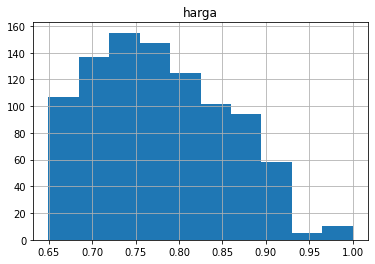

In [36]:
_ = egg_df.hist()

In [37]:
#Get the price and time step from dataframe
temp = egg_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [38]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

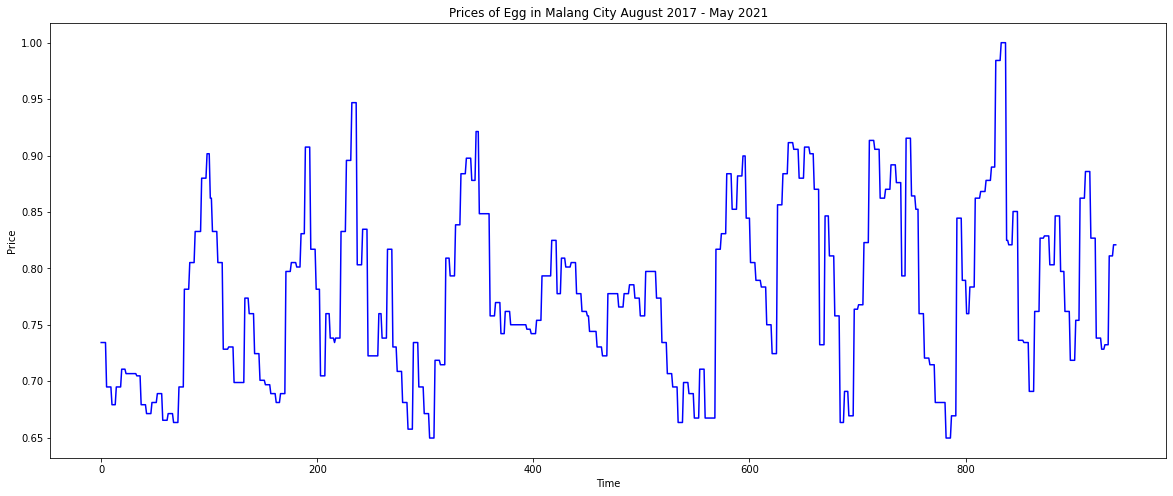

In [39]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Egg in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

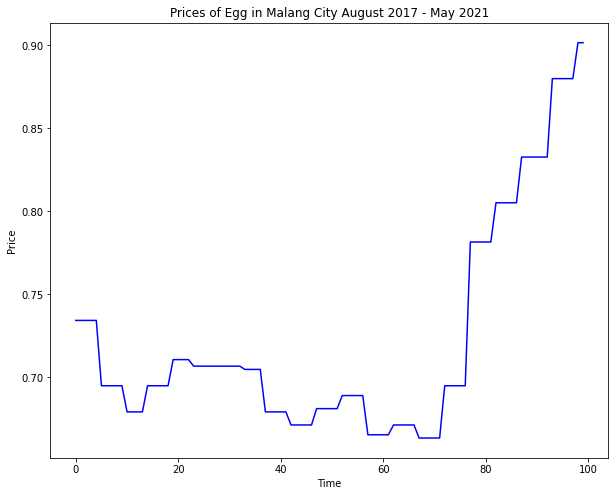

In [40]:
plt.figure(figsize=(10, 8))
plot_dataset(time=time[:100], series=price[:100], color='b', title='Prices of Egg in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [41]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the Dataset 

In [42]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [43]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer

In [44]:
window_size = 100
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [19]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 34s 71ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 2/200
2/2 [==============================] - 0s 18ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 3/200
2/2 [==============================] - 0s 14ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 5/200
2/2 [==============================] - 0s 14ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 6/200
2/2 [==============================] - 0s 14ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 7/200
2/2 [==============================] - 0s 10ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 8/200
2/2 [==============================] - 0s 15ms/step - loss: 0.3547 - mean_absolute_error: 0.8380
Epoch 9/200
2/2 [=========

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 11,937
Trainable params: 11,937
Non-trainable params: 0
_________________________________________________________________


(0.0001, 0.1, 0.0, 0.2)

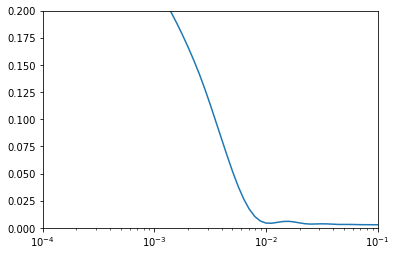

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.2])

In [45]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=500, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/500
2/2 [==============================] - 4s 874ms/step - loss: 0.2186 - mean_absolute_error: 0.6413 - val_loss: 0.0060 - val_mean_absolute_error: 0.0759
Epoch 2/500
2/2 [==============================] - 0s 176ms/step - loss: 0.0299 - mean_absolute_error: 0.1845 - val_loss: 0.0949 - val_mean_absolute_error: 0.4227
Epoch 3/500
2/2 [==============================] - 0s 172ms/step - loss: 0.0729 - mean_absolute_error: 0.3610 - val_loss: 0.0036 - val_mean_absolute_error: 0.0684
Epoch 4/500
2/2 [==============================] - 0s 171ms/step - loss: 0.0093 - mean_absolute_error: 0.1103 - val_loss: 0.0395 - val_mean_absolute_error: 0.2709
Epoch 5/500
2/2 [==============================] - 0s 183ms/step - loss: 0.0396 - mean_absolute_error: 0.2716 - val_loss: 0.0220 - val_mean_absolute_error: 0.1964
Epoch 6/500
2/2 [==============================] - 0s 199ms/step - loss: 0.0157 - me

In [46]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


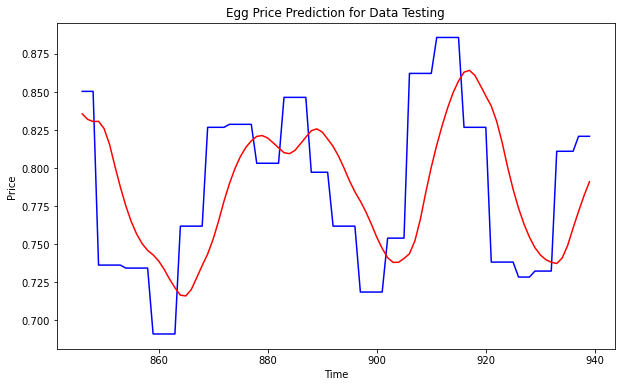

In [47]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Egg Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Egg Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

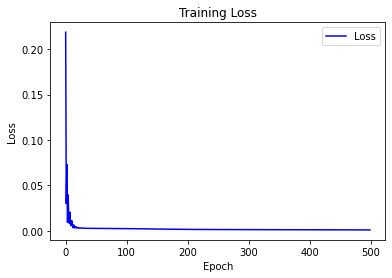

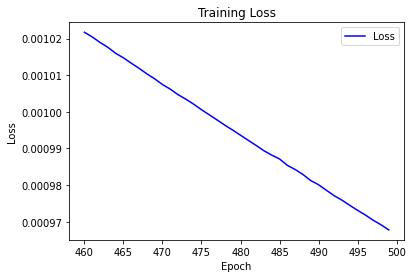

<Figure size 432x288 with 0 Axes>

In [48]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[460:]
epoch_num_zoom = [x+460 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [49]:
rnn_forecast

array([0.8356147 , 0.831973  , 0.83056676, 0.83069086, 0.8260561 ,
       0.8157753 , 0.80122983, 0.78748196, 0.77514046, 0.7647568 ,
       0.7565095 , 0.75028455, 0.7458712 , 0.7429264 , 0.73900867,
       0.7336089 , 0.72713125, 0.7213724 , 0.7164575 , 0.7159272 ,
       0.7201567 , 0.7279657 , 0.73594093, 0.7434727 , 0.7531673 ,
       0.7651097 , 0.77827865, 0.7898189 , 0.79962885, 0.80752164,
       0.8135464 , 0.8178654 , 0.82078516, 0.8213572 , 0.81975013,
       0.8166075 , 0.8132973 , 0.8101121 , 0.8094406 , 0.8115916 ,
       0.81589   , 0.8203019 , 0.8245125 , 0.8257612 , 0.82369   ,
       0.8190659 , 0.8142179 , 0.8077856 , 0.8000238 , 0.7916614 ,
       0.784353  , 0.7782383 , 0.7712933 , 0.76325744, 0.7546296 ,
       0.7472105 , 0.74106777, 0.73798436, 0.7380611 , 0.7405774 ,
       0.7436848 , 0.7522155 , 0.7663453 , 0.7841475 , 0.8005784 ,
       0.815018  , 0.828008  , 0.8395642 , 0.8495415 , 0.8572587 ,
       0.86302286, 0.8642053 , 0.86087596, 0.85427827, 0.84738

In [50]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [51]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.7843145132064819],
  [0.7713674902915955],
  [0.775272786617279],
  [0.7772045731544495],
  [0.7788218855857849],
  [0.7796777486801147],
  [0.7783831357955933],
  [0.7746558785438538],
  [0.7690017819404602],
  [0.7622079253196716],
  [0.7554928064346313],
  [0.7494064569473267],
  [0.7442701458930969],
  [0.7401025295257568],
  [0.7407281398773193],
  [0.7464934587478638],
  [0.7560769319534302],
  [0.7657376527786255],
  [0.7753249406814575],
  [0.7842820286750793]]]

In [52]:
round(rnn_forecast[-1][-1][0]*max)

19921

In [55]:
  model.save("egg_model")

INFO:tensorflow:Assets written to: egg_model/assets


INFO:tensorflow:Assets written to: egg_model/assets


In [56]:
!zip -r egg_model.zip egg_model

  adding: egg_model/ (stored 0%)
  adding: egg_model/assets/ (stored 0%)
  adding: egg_model/keras_metadata.pb (deflated 91%)
  adding: egg_model/saved_model.pb (deflated 90%)
  adding: egg_model/variables/ (stored 0%)
  adding: egg_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: egg_model/variables/variables.index (deflated 66%)
